In [154]:
#from __future__ import print_function, division, absolute_import, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pickle
import os
import matlab.engine
from scipy.interpolate import interp1d

#bin_vector= [16,30.8,37.5,45,60]
#bin_vector= [16,37.5,60]
bin_vector = [16,60]
#bin_vector = [58,60]

# Modified these paths
script_dir = os.path.dirname(os.getcwd()) #<-- absolute dir the script is in
rel_path = 'tf_unet/Attenuation_with_air_0_1.pkl'
abs_file_path = os.path.join(script_dir, rel_path)

# This is the part that imports the files
with open(abs_file_path,'rb') as f:  # Python 3: open(..., 'rb')
    Attenuation, Attenuation2, Spec, Air = pickle.load(f)
Ev = Spec[:,0]
Int = Spec[:,1]
#Int = Int*10000/sum(Int)

# f4 = interp1d(Ev,Int,kind='quadratic')
Ev_long = np.linspace(Ev[0],Ev[-1],len(Ev)*5 - 4)
Int_long = f4(Ev_long)

#inds = Ev%1 == 0

Int_long = Int
Ev_long = Ev

Int_long = Int_long*10000/sum(Int_long)
#Convert the bin vector from energies to indices
nbins = len(bin_vector)-1

for ii in range(nbins+1):
    bin_vector[ii] = min(range(len(Ev_long)), key=lambda i: abs(Ev_long[i]-bin_vector[ii]))

Int_long = Int_long*10000/sum(Int_long)


pixel_value = 0.

# hard coding a start to avoid the k edges
f1 = interp1d(np.log(Attenuation[12:,0]),np.log(Attenuation[12:,6]))#,kind='quadratic')
f2 = interp1d(np.log(Attenuation2[19:,0]),np.log(Attenuation2[19:,6]))#,kind='quadratic')
f3 = interp1d(np.log(Air[:,0]),np.log(Air[:,6]))#,kind='quadratic')

plt.figure()
plt.plot(np.log(Attenuation[12:,0]),np.log(Attenuation[12:,6]))
plt.plot(np.log(Attenuation2[19:,0]),np.log(Attenuation2[19:,6]))
plt.plot(np.log(Ev_long/1000.),np.log(Int_long),'b*')

print(Attenuation[12:,6])

t_cart = 0
nbins  = 1
for t_water in [4,5,8,10]:
    for jj in range(nbins): 
    # finding the attenuation for the low image
        for ii,energy in enumerate(Ev_long[bin_vector[jj]:bin_vector[jj+1]]):
            # Finding the attenuation in the vector
#            mu = np.interp(energy/1000.,Attenuation[:,0],Attenuation[:,6])
#              f2 = interp1d(energy/1000.,Attenuation2[:,0],Attenuation2[:,7])
#              f3 = interp1d(energy/1000.,Air[:,0],Air[:,6])

            mu = f1(np.log(energy/1000.))
            mu2 = f2(np.log(energy/1000.))
            mu_air = f3(np.log(energy/1000.))
#             Finding the attenuation in the vector
#                 mu = f1(np.log(energy/1000.))
#                 mu2 = f2(np.log(energy/1000.))
#                 mu_air = f3(np.log(energy/1000.))

            mu = np.exp(mu)
            mu2 = np.exp(mu2)
            mu_air = np.exp(mu_air)
#             print(mu)
            plt.figure(1)
            plt.plot(np.log(energy/1000.),np.log(mu),'r*')

            #mu = 0.2073
            # wrong density of water to match the image
            pixel_value += (Int_long[ii+bin_vector[jj]]*np.exp(-mu*t_water*1.015))
#                         *np.exp(-mu2*t_cart*1.1)*np.exp(-mu_air*0*0.00120479)
            
            plt.figure(2)
            plt.plot(ii,pixel_value,'k*')
            
        print(pixel_value)
        pixel_value = 0.

#1056
#3110
#1799

#3546 for 5cm 59.5-60 1
#3524 for 5cm 58-60 1
#3518 for 5cm 58-60 0.1
#3522 for 5cm 58-60 0.5
#1241 for 10cm 58-60 0.5
#627 for 10cm 16-60 0.5

print(Ev_long)
print(Int_long)

/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log


[5.142   1.682   0.8266  0.3812  0.2682  0.2244  0.2023  0.1793  0.1662
 0.1463  0.1331  0.1153  0.1031  0.09413 0.08703 0.07642 0.06871 0.06799
 0.06144 0.05592 0.04797 0.04741 0.03846 0.0329  0.02923 0.02664]
2896.698036683219
2170.916780526676
942.2277228612468
550.5701109841996
[16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5
 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5
 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5
 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5
 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.  49.5 50.  50.5
 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5 57.  57.5
 58.  58.5 59.  59.5 60. ]
[  1.96340834   3.06196406   4.79595293   6.84639314   9.80016802
  13.06512051  17.44680549  22.03312874  27.85835884  33.6368966
  40.64927819  47.58052865  55.78101298  63.31364851  71.98137333
  80.03437532  89.09338502  97.05189767 105.77906955 113.54452241
 

In [66]:
Ev_long[bin_vector]


array([59., 60.])

In [27]:
image2 = np.reshape(image,[image.size],order='F').copy()
image2 = list(np.squeeze(image))

image2 = matlab.double(image2)
nbins = matlab.double([4])
SNR = matlab.double([100])
eng = matlab.engine.start_matlab()
width = matlab.double([width])
height = matlab.double([height])

In [24]:
import io
out = io.StringIO()
err = io.StringIO()

im_hard = eng.Analysis_DES_validation(image2,matlab.double(ML_labels))

In [25]:
print(out.getvalue())
print(err.getvalue())


ans =

   512   512     4





In [35]:
import scipy.io as sio
sio.savemat("images.mat", {"image":image})

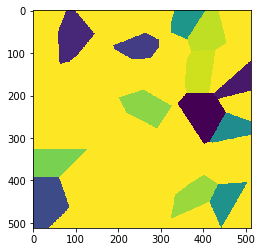

In [29]:
plt.imshow(image[:,:,1])

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
im_this = np.float32(im_hard)

In [52]:
nb = 4
for jj in range(nb): 
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
    ax[0].imshow(image[:,:,jj], aspect="auto")
    ax[1].imshow(labels, aspect="auto")

TypeError: '<' not supported between instances of 'tuple' and 'int'

In [5]:
Ev[107]

60.0

In [13]:
x = sum(Int)

In [2]:
from __future__ import print_function, division, absolute_import, unicode_literals

import numpy as np
import random
import math
import pickle
import os

import matlab.engine
from scipy.interpolate import interp1d

sigma = 10

plateau_min = -2
plateau_max = 2

r_min = 1
r_max = 200
bin_vector= [16,30.8,37.5,45,60]

width, height, cnt = [512,512,10]
    

In [3]:
num_cells = cnt

# Modified these paths
script_dir = os.path.dirname(os.getcwd()) #<-- absolute dir the script is in
rel_path = 'tf_unet/Attenuation_with_air_0_1.pkl'
abs_file_path = os.path.join(script_dir, rel_path)

# This is the part that imports the files
with open(abs_file_path,'rb') as f:  
    Attenuation, Attenuation2, Spec, Air = pickle.load(f)
Ev = Spec[:,0]
Int = Spec[:,1]

f4 = interp1d(Ev,Int)
Ev_long = np.linspace(Ev[0],Ev[-1],len(Ev)*5 - 4)
Int_long = f4(Ev_long)

Int_long = Int_long*10000/sum(Int_long)
#Convert the bin vector from energies to indices
nbins = len(bin_vector)-1

for ii in range(nbins+1):
    bin_vector[ii] = min(range(len(Ev_long)), key=lambda i: abs(Ev_long[i]-bin_vector[ii]))
    
image = np.ones((width,height,nbins))
labels = np.zeros([width,height],dtype=np.bool)
imgx, imgy = width, height
nx = [] # hold the x value
ny = [] # holds the y value
nr = np.zeros([nbins,cnt]) # low energy image
nr2 = [] # high energy image
label = [] # labels whether or not the cell has cartilage

f1 = interp1d(np.log(Attenuation[12:,0]),np.log(Attenuation[12:,6]))#,kind='quadratic')
f2 = interp1d(np.log(Attenuation2[19:,0]),np.log(Attenuation2[19:,6]))#,kind='quadratic')
f3 = interp1d(np.log(Air[:,0]),np.log(Air[:,6]))#,kind='quadratic')


target_SNR = 100
# Finding the singnal in water that will be the basis for the noise
signal = 3.1459*10**3
# Finding the target noise
sigma = signal / target_SNR
# Finding the signal strength that would give the correct poisson noise
correct_signal = (signal / sigma)**2.

for i in range(num_cells):

    # choosing random place for the cell
    nx.append(random.randrange(imgx))
    ny.append(random.randrange(imgy))
    rr = random.random()
    pp = random.random()

    # making a random value for the cartilage
    if i%4==0:
        t_cart = random.uniform(0.1,4)
        label.append(0)
    else:
        label.append(1)
        t_cart = 0.

    # Attenuating
    pixel_value = 0.

    for ll,t_total in enumerate([4,6,8]):

        for jj in range(nbins): 
        # finding the attenuation for the low image
            for ii,energy in enumerate(Ev_long[bin_vector[jj]:bin_vector[jj+1]]):
                mu = f1(np.log(energy/1000.))
                mu2 = f2(np.log(energy/1000.))
                mu_air = f3(np.log(energy/1000.))
                mu = np.exp(mu)
                mu2 = np.exp(mu2)
                mu_air = np.exp(mu_air)

#                 plt.figure(1)
#                 plt.plot(np.log(energy/1000.),np.log(mu),'r*')

                #mu = 0.2073
                # wrong density of water to match the image
        
                t_water = t_total - t_cart
                pixel_value += (Int_long[ii+bin_vector[jj]]*np.exp(-mu*t_water*1.015)
                             *np.exp(-mu2*t_cart*1.1)*np.exp(-mu_air*30*0.00120479))

#                 plt.figure(2)
#                 plt.plot(ii,pixel_value,'k*')

#             print(pixel_value)

            nr[jj,i] = pixel_value
    
for y in range(imgy):
    for x in range(imgx):
        dmin = math.hypot(imgx-1, imgy-1)
        j = -1
        for i in range(num_cells):
            d = math.hypot(nx[i]-x, ny[i]-y)
            if d < dmin:
                dmin = d
                j = i

        # Generating some poisson noise\
        for kk in range(nbins):
            image[x,y,kk] = nr[kk,j] + np.random.normal(0, np.sqrt(nr[kk,j]*correct_signal/signal))

        labels[x,y] = label[j]

In [4]:
matlab_reshape = np.reshape(image,[image.size],order='F').copy()
matlab_reshape = list(np.squeeze(matlab_reshape)).copy()
matlab_reshape = matlab.double(matlab_reshape)

eng = matlab.engine.start_matlab()
ys = eng.net_val(matlab_reshape)

In [11]:
im_cart = np.reshape(ys,[width,height],order='F').copy()
#return image, labels

In [13]:
%matplotlib qt
import matplotlib.pyplot as plt

plt.imshow(im_cart[:,:])
plt.figure()
plt.imshow(image[:,:,1])

(1, 300)

In [46]:
np.size(matlab_reshape)

(1, 1048576)

In [47]:
512*512*4

1048576

In [48]:
1048576/262144

4.0

In [52]:
import scipy.io as sio
sio.savemat("images.mat", {"image":image})